# Capstone 3: Exploratory Data Analysis
<b>PROJECT GOAL</b><br>
The goal of this project is to understand and predict the valuation of publicly-traded companies as measured by market capitalization (the target or response variable).  Financial statement data will be used as predictor variables (features) to assess whether regression models of these fundamental variables can predict future market capitalization.<br>

<b>DATA</b><br>
All data are sourced from Alpha Vantage via their API (https://www.alphavantage.co/documentation/).

<i>response variable (target)</i><br>
market capitalization = [number of shares outstanding] x [share price]<br><br>
<i>predictor variables (features)</i><br>
Features will be metrics from financial statements such as revenue, revenue growth year-over-year, etc.  An initial set of metrics was defined in the data wrangling notebook and this notebook, as part of an exploratory data analysis, will refine this feature set.

<b>EXPLORATORY DATA ANALYSIS NOTEBOOK</b><br>
The purpose of this notebook is to:
<ol type="1">
  <li>abc</li>
  <li>abc</li>
</ol> 

## 1 Import Python Modules, Load Data

Import Python modules, load target and feature data from data wrangling notebook.

In [1]:
import pandas as pd
import numpy as np
import datetime as dttm

from sklearn.preprocessing import StandardScaler, RobustScaler
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

import matplotlib.pyplot as plt
import seaborn as sns

import json

In [2]:
#as of date
statusdate01 = dttm.date(2021,9,30)

In [3]:
#load target, feature data
data_elmt011 = 'yxdata'

#json - df_sec_res
filnm011 = '../data/sec_' + data_elmt011 + '_dw_' + statusdate01.strftime('%Y%m%d') + '.json'

with open(filnm011) as f011:
    sec_res_dict011 = json.load(f011)
        
df_sec_yxdata011 = pd.DataFrame.from_dict(sec_res_dict011)

lst_yxdata_dates011 = ['fisc_date_t', 'fisc_date_tp1', 'meas_date_t', 'meas_date_tp1', 
    'rpt_date_t', 'rpt_date_tp1', 'fisc_date_tm1', 'fisc_date_tm4', 'fisc_date_tm5']

for lst_date_itm011 in lst_yxdata_dates011:
    df_sec_yxdata011.loc[:,lst_date_itm011] = pd.to_datetime(df_sec_yxdata011.loc[:,lst_date_itm011])
    
del f011, sec_res_dict011
#df_sec_yxdata011

In [4]:
df_sec_yxdata011.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11897 entries, 0 to 11896
Data columns (total 65 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   ticker          11897 non-null  object        
 1   mkt_cap_202109  11897 non-null  float64       
 2   fisc_seq        11897 non-null  float64       
 3   fisc_intvl      11897 non-null  float64       
 4   fisc_date_t     11897 non-null  datetime64[ns]
 5   fisc_date_tp1   11897 non-null  datetime64[ns]
 6   meas_date_t     11897 non-null  datetime64[ns]
 7   meas_date_tp1   11897 non-null  datetime64[ns]
 8   rpt_date_t      11897 non-null  datetime64[ns]
 9   rpt_date_tp1    11897 non-null  datetime64[ns]
 10  rd_t_estflg     11897 non-null  int64         
 11  rd_tp1_estflg   11897 non-null  int64         
 12  ticker_etf      11897 non-null  object        
 13  fisc_date_tm1   11892 non-null  datetime64[ns]
 14  fisc_date_tm4   11801 non-null  datetime64[ns]
 15  fisc_da

## 2 Define In-Scope Sample, Metrics

<b>IN-SCOPE FLAG, CORE ATTRIBUTES & METRICS</b>

Create a column to flag records as in/out of scope for further analysis.

In [5]:
#create 'inscope_flg'
df_sec_yxdata011.loc[:,'inscope_flg'] = True

#core metrics (ticker, currency, target, core features)
lst_yx_coreattmet011 = ['ticker','mkt_cap_202109','rpt_ccy','inscope_flg',
    'fisc_date_t', 'fisc_date_tm1', 'fisc_date_tm4', 'fisc_date_tm5',
    'mktcap_sec_tp1','clsadj_etf_t',
    'rev', 'rev_yoy', 'rev_yoy_qdq', 
    'gp', 'gp_mgn', 'gp_mgn_ydy', 
    'ni', 'ni_ydy', 'ni_mgn', 'ni_mgn_ydy', 
    'sh_iss', 'sh_rprch', 'div', 'div_ydy',
    'cf_op', 'cf_op_ydy', 'cf_op_mgn', 'cf_op_mgn_ydy']

<b>CURRENCY - USD ONLY</b>

Analysis will include only stocks reporting in currency USD.

In [6]:
#USD records, exclude non-USD
is_yx_USD011 = df_sec_yxdata011.loc[:,'rpt_ccy'] == 'USD'
df_sec_yxdata011.loc[~is_yx_USD011,'inscope_flg'] = False
is_yx_inscope011 = df_sec_yxdata011.loc[:,'inscope_flg'] == True
is_yx_inscope011.sum()

11697

<b>NaN VALUES - EXCLUDE</b>

Include only records without missing data.

In [7]:
#exclude NaN for core metrics
is_yx_notNaN011 = df_sec_yxdata011.loc[:,lst_yx_coreattmet011].notna().all(axis=1)
df_sec_yxdata011.loc[~is_yx_notNaN011,'inscope_flg'] = False
is_yx_inscope011 = df_sec_yxdata011.loc[:,'inscope_flg'] == True
is_yx_inscope011.sum()

10780

<b>REVENUE - LOWER BOUND</b>

Include only companies with median quarterly revenue of \\$5m or higher, or \\$20m per year, because revenue is a foundational financial metric from which all other financial outcomes are ultimately derived.  The companies is this analysis are \\$1b and above market capitalization, so a firm with $20m in annual revenue at a valuation of \\$1b or more would be typically be considered highly valued and quite speculative.  Firms that are even more speculative with under \\$20m in annual revenue are considered out of scope for this analysis.

In [8]:
#revenue lower bound
rev_lwbd011 = 5*10**6

df_tick_revmed011 = df_sec_yxdata011.loc[:,['ticker','rev']].groupby('ticker').median()
is_tickrev_med_lwbd011 = df_tick_revmed011.loc[:,'rev'] >= rev_lwbd011
lst_tickrev_med_lwbd011 = list(df_tick_revmed011.loc[is_tickrev_med_lwbd011,:].index)

is_yx_tickrev_med_lwbd011 = df_sec_yxdata011.loc[:,'ticker'].isin(lst_tickrev_med_lwbd011)
df_sec_yxdata011.loc[~is_yx_tickrev_med_lwbd011,'inscope_flg'] = False
is_yx_inscope011 = df_sec_yxdata011.loc[:,'inscope_flg'] == True
is_yx_inscope011.sum()

10565

<b>MARKET CAP - INCONSISTENT VALUES</b>

Market capitalization is calculated from the balance sheet (number of shares outstanding) and the stock price as [market capitalization] = [number of shares outstanding] x [share price].  Market capitalization is also available as a daily snapshot value from Alpha Vantage.  I compared the calculated value to the snapshot value.  In the case of extreme differences (2x or more relative difference), I excluded these stocks from the analysis as inconsistent values.  Ticker BRK-A is an extreme example.

In [9]:
#market cap: inconsistent values      mktcap_sec_tp1 vs mkt_cap_202109
is_yx_inscope011 = df_sec_yxdata011.loc[:,'inscope_flg'] == True

df_sec_mktcap011 = df_sec_yxdata011.loc[:,['ticker','mkt_cap_202109','fisc_date_t','mktcap_sec_tp1']]
df_sec_mktcap011.loc[:,'mkt_cap_devabspct'] = df_sec_mktcap011.apply( lambda rw: (rw[3] - rw[1])/rw[1], axis=1 ).abs()

df_sec_mktcap011.loc[is_yx_inscope011,:].sort_values(by='mkt_cap_devabspct',ascending=False).head(30)

,ticker,mkt_cap_202109,fisc_date_t,mktcap_sec_tp1,mkt_cap_devabspct
35,BRK-A,6.240809e+11,2021-03-31,1.512403e+15,2422.408636
36,BRK-A,6.240809e+11,2020-12-31,1.443749e+15,2312.400620
37,BRK-A,6.240809e+11,2020-09-30,1.297145e+15,2077.488375
38,BRK-A,6.240809e+11,2020-06-30,1.220736e+15,1955.054086
39,BRK-A,6.240809e+11,2020-03-31,1.006762e+15,1612.190821
7697,TAL,3.108327e+09,2020-11-30,4.700319e+10,14.121700
7698,TAL,3.108327e+09,2020-08-31,4.573000e+10,13.712094
2687,PCGU,1.785960e+10,2020-09-30,2.380899e+11,12.331203
1500,BGNE,3.433170e+10,2021-03-31,4.286535e+11,11.485648
2686,PCGU,1.785960e+10,2020-12-31,2.185508e+11,11.237161


In [10]:
#percentiles
df_sec_mktcap011.loc[is_yx_inscope011,['mkt_cap_devabspct']].quantile([0.950,0.990,0.995,0.998,0.999]).T

,0.950,0.990,0.995,0.998,0.999
mkt_cap_devabspct,0.739514,1.228862,2.419392,5.327207,10.236213


In [11]:
#market cap deviation cutoff, by ticker
is_mc_dvabspt_notupbd011 = df_sec_mktcap011.loc[:,'mkt_cap_devabspct'] > 2

ary_tickmc_dvabspt_notupbd011 = df_sec_mktcap011.loc[is_mc_dvabspt_notupbd011,'ticker'].unique()
lst_tickmc_dvabspt_notupbd011 = list(ary_tickmc_dvabspt_notupbd011)

is_yx_tickmc_dvabspt_notupbd011 = df_sec_yxdata011.loc[:,'ticker'].isin(lst_tickmc_dvabspt_notupbd011)
df_sec_yxdata011.loc[is_yx_tickmc_dvabspt_notupbd011,'inscope_flg'] = False
is_yx_inscope011 = df_sec_yxdata011.loc[:,'inscope_flg'] == True
is_yx_inscope011.sum()

10448

(900000000.0, 200000000000.0)

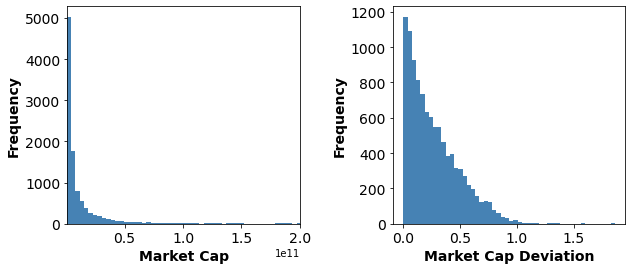

In [12]:
#histogram
fig01, axes01 = plt.subplots(nrows=1,ncols=2,figsize=(10,4))
fig01.subplots_adjust(wspace=0.4)

lst_colset_plt01 = ['mktcap_sec_tp1','mkt_cap_devabspct']
lst_lblset_plt01 = ['Market Cap','Market Cap Deviation']
lst_bins_plt01 = [600,50]

for idx001 in range(0,len(lst_colset_plt01)):
    colplt01 = lst_colset_plt01[idx001]
    
    df_sec_mktcap011.loc[is_yx_inscope011,colplt01].plot(ax=axes01[idx001],
        kind='hist',bins=lst_bins_plt01[idx001], color='steelblue')
    axes01[idx001].set_xlabel(lst_lblset_plt01[idx001], fontsize=14.0, fontweight='bold')
    axes01[idx001].tick_params(axis='x', labelsize=14)
    axes01[idx001].set_ylabel('Frequency', fontsize=14.0, fontweight='bold') 
    axes01[idx001].tick_params(axis='y', labelsize=14) 
    
axes01[0].set_xlim(0.9*10**9, 200*10**9)

<b>REVENUE: EXTREME VALUES</b>

One ticker with an extreme value for revenue is excluded, SQM.  Other tickers with extreme revenue, such as Moderna (MRNA) and Fulgent Genetics (FLGT), are biotech firms that experienced very large surges in business in response to the coronavirus pandemic.

In [13]:
#revenue: extreme values
#revenue value vs median revenue by ticket
df_sec_revun011 = pd.concat( [ df_sec_yxdata011.loc[:,['ticker','mkt_cap_202109','fisc_date_t','rev']], 
    df_sec_yxdata011.loc[:,['ticker','mkt_cap_202109','fisc_date_tm5','rev_pqpy']].rename(
        columns={'fisc_date_tm5':'fisc_date_t','rev_pqpy':'rev'}) ], 
        ignore_index=True).drop_duplicates(subset=['ticker','fisc_date_t'])
df_tick_revmed011 = df_sec_revun011.loc[:,['ticker','rev']].groupby('ticker').median()

#deviation from median
df_sec_rev011 = df_sec_yxdata011.loc[:,['ticker','mkt_cap_202109','fisc_date_t','rev']] 
df_sec_rev011.loc[:,'rev_med'] = df_sec_rev011.apply( lambda rw: df_tick_revmed011.loc[rw[0],'rev'], axis=1 )
df_sec_rev011.loc[:,'rev_devabspct'] = df_sec_rev011.apply( lambda rw: 
    (rw[3] - rw[4])/rw[4] if rw[4] > 0 else np.NaN, axis=1 ).abs()

df_sec_rev011.loc[is_yx_inscope011,:].sort_values(by='rev_devabspct',ascending=False).head(20)

,ticker,mkt_cap_202109,fisc_date_t,rev,rev_med,rev_devabspct
2973,SQM,1.543017e+10,2021-03-31,1.366430e+11,483598500.0,281.554640
360,MRNA,1.376796e+11,2021-03-31,1.937000e+09,26233500.0,72.836888
5373,BPMC,5.958148e+09,2020-09-30,7.470210e+08,10253000.0,71.858773
3221,NVAX,1.352633e+10,2021-03-31,4.472290e+08,7471500.0,58.857994
5224,DNLI,6.201207e+09,2020-12-31,3.168150e+08,6885000.0,45.015251
8534,FLGT,2.489531e+09,2021-03-31,3.594290e+08,9385500.0,37.296202
3222,NVAX,1.352633e+10,2020-12-31,2.796590e+08,7471500.0,36.430101
8506,RCUS,2.515210e+09,2020-09-30,6.453000e+07,1750000.0,35.874286
8535,FLGT,2.489531e+09,2020-12-31,2.949780e+08,9385500.0,30.429119
7655,ITCI,3.128398e+09,2021-03-31,1.587833e+07,572046.0,26.757084


In [14]:
#percentiles
df_sec_rev011.loc[is_yx_inscope011,['rev_devabspct']].quantile([0.950,0.990,0.995,0.998,0.999]).T

,0.950,0.990,0.995,0.998,0.999
rev_devabspct,0.724495,1.622812,3.217886,9.053498,20.425586


In [15]:
#revenue deviation cutoff, by ticker
is_rev_dvabspt_notupbd011 = df_sec_rev011.loc[:,'rev_devabspct'] > 100

ary_tickrev_dvabspt_notupbd011 = df_sec_rev011.loc[is_rev_dvabspt_notupbd011,'ticker'].unique()
lst_tickrev_dvabspt_notupbd011 = list(ary_tickrev_dvabspt_notupbd011)

is_yx_tickrev_dvabspt_notupbd011 = df_sec_yxdata011.loc[:,'ticker'].isin(lst_tickrev_dvabspt_notupbd011 )
df_sec_yxdata011.loc[is_yx_tickrev_dvabspt_notupbd011,'inscope_flg'] = False
is_yx_inscope011 = df_sec_yxdata011.loc[:,'inscope_flg'] == True
is_yx_inscope011.sum()

10443

(0.0, 4.0)

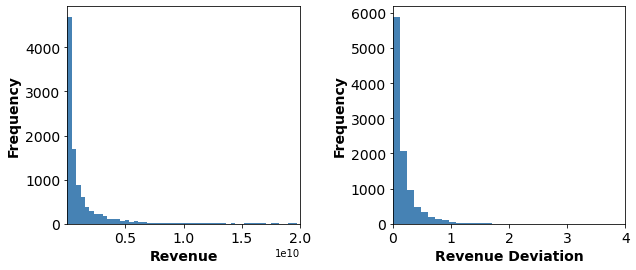

In [16]:
#histogram
fig02, axes02 = plt.subplots(nrows=1,ncols=2,figsize=(10,4))
fig02.subplots_adjust(wspace=0.4)

lst_colset_plt02 = ['rev','rev_devabspct']
lst_lblset_plt02 = ['Revenue','Revenue Deviation']
lst_bins_plt02 = [400,600]

for idx002 in range(0,len(lst_colset_plt02)):
    colplt02 = lst_colset_plt02[idx002]
    
    df_sec_rev011.loc[is_yx_inscope011,colplt02].plot(ax=axes02[idx002],
        kind='hist',bins=lst_bins_plt02[idx002], color='steelblue')
    axes02[idx002].set_xlabel(lst_lblset_plt02[idx002], fontsize=14.0, fontweight='bold')
    axes02[idx002].tick_params(axis='x', labelsize=14)
    axes02[idx002].set_ylabel('Frequency', fontsize=14.0, fontweight='bold') 
    axes02[idx002].tick_params(axis='y', labelsize=14) 
    
axes02[0].set_xlim(4*10**6, 20*10**9)
axes02[1].set_xlim(0, 4)

<b>GROSS PROFIT</b>

Three measures of gross profit...

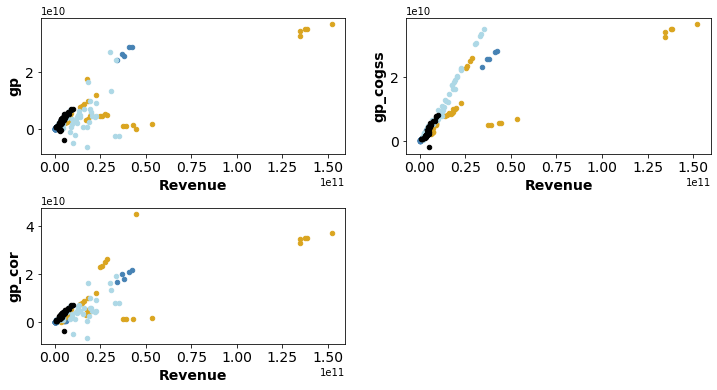

In [17]:
#consistent vs rev
lst_tch_tick011 = ['CRM','MSFT','ADBE','NOW','SNAP','ADSK','ZM','DOCU','CRWD','DDOG']
lst_cst_tick011 = ['PG','KO','PEP','WMT','COST','PM','MO','MDLZ','EL','CL']
lst_bnk_tick011 = ['JPM','BAC','WFC','MS','GS','BLK','SCHW','AXP','SPGI','PNC']
lst_utl_tick011 = ['NEE','DUK','SO','D','EXC','AEP','SRE','XEL','AWK','ED']

is_tchset_001 = df_sec_yxdata011.loc[:,'ticker'].isin(lst_tch_tick011)
is_cstset_001 = df_sec_yxdata011.loc[:,'ticker'].isin(lst_cst_tick011)
is_bnkset_001 = df_sec_yxdata011.loc[:,'ticker'].isin(lst_bnk_tick011)
is_utlset_001 = df_sec_yxdata011.loc[:,'ticker'].isin(lst_utl_tick011)

#scatterplot
fig03, axes03 = plt.subplots(nrows=2,ncols=2,figsize=(12,6))
fig03.subplots_adjust(wspace=0.2,hspace=0.4)

axsflt03 = axes03.flatten()

lst_colset_plt03 = ['gp','gp_cogss','gp_cor']
lst_lblset_plt03 = lst_colset_plt03

for idx003 in range(0,len(lst_colset_plt03)):
    colplt03 = lst_colset_plt03[idx003]
    
    df_sec_yxdata011.loc[is_yx_inscope011 & is_tchset_001,:].plot(x='rev',y=lst_colset_plt03[idx003],kind='scatter',
        ax=axsflt03[idx003],color='steelblue')
    df_sec_yxdata011.loc[is_yx_inscope011 & is_cstset_001,:].plot(x='rev',y=lst_colset_plt03[idx003],kind='scatter',
        ax=axsflt03[idx003],color='goldenrod')
    df_sec_yxdata011.loc[is_yx_inscope011 & is_bnkset_001,:].plot(x='rev',y=lst_colset_plt03[idx003],kind='scatter',
        ax=axsflt03[idx003],color='lightblue')
    df_sec_yxdata011.loc[is_yx_inscope011 & is_utlset_001,:].plot(x='rev',y=lst_colset_plt03[idx003],kind='scatter',
        ax=axsflt03[idx003],color='black')
    axsflt03[idx003].set_xlabel('Revenue', fontsize=14.0, fontweight='bold')
    axsflt03[idx003].tick_params(axis='x', labelsize=14)
    axsflt03[idx003].set_ylabel(colplt03, fontsize=14.0, fontweight='bold') 
    axsflt03[idx003].tick_params(axis='y', labelsize=14)
    
axsflt03[-1].set_visible(False)

In [18]:
#redefine gp metrics
#gp_mgn
df_sec_yxdata011.loc[:,'gp_mgn'] = df_sec_yxdata011.apply(lambda rw: 
    rw['gp']/rw['rev'] if rw['rev'] != 0 else np.NaN, axis=1)
df_sec_yxdata011.loc[:,'gp_mgn_py'] = df_sec_yxdata011.apply(lambda rw: 
    rw['gp_py']/rw['rev_py'] if rw['rev_py'] != 0 else np.NaN, axis=1)
df_sec_yxdata011.loc[:,'gp_mgn_ydy'] = df_sec_yxdata011.apply(lambda rw: (rw['gp_mgn'] - rw['gp_mgn_py']), axis=1)

<b>OTHER FEATURES: EXTREME VALUES</b>

Explanation****

In [19]:
#descriptive statistics
lst_yx_coremet031 = [
    'mktcap_sec_tp1',
    'clsadj_etf_t',
    'rev', 'rev_yoy', 'rev_yoy_qdq', 
    'gp', 'gp_mgn', 'gp_mgn_ydy', 
    'ni', 'ni_ydy', 'ni_mgn', 'ni_mgn_ydy', 
    'sh_iss', 'sh_rprch', 'div', 'div_ydy',
    'cf_op', 'cf_op_ydy', 'cf_op_mgn', 'cf_op_mgn_ydy']
df_sec_yxdata011.loc[is_yx_inscope011,lst_yx_coremet031].describe()

,mktcap_sec_tp1,clsadj_etf_t,rev,rev_yoy,rev_yoy_qdq,gp,gp_mgn,gp_mgn_ydy,ni,ni_ydy,ni_mgn,ni_mgn_ydy,sh_iss,sh_rprch,div,div_ydy,cf_op,cf_op_ydy,cf_op_mgn,cf_op_mgn_ydy
count,1.044300e+04,10443.000000,1.044300e+04,10443.000000,10443.000000,1.044300e+04,10443.000000,10443.000000,1.044300e+04,1.044300e+04,1.044300e+04,1.044300e+04,1.044300e+04,1.044300e+04,1.044300e+04,1.044300e+04,1.044300e+04,1.044300e+04,1.044300e+04,1.044300e+04
mean,2.032177e+10,168.631490,2.172846e+09,0.289043,-6.751538,8.263266e+08,-82.733054,-83.205012,1.451715e+08,-2.138363e+07,4.339639e+03,4.339812e+03,1.485962e+07,7.517570e+07,9.559211e+07,-6.275962e+06,3.198641e+08,-1.877444e+07,-2.791980e+02,-2.791656e+02
std,8.714600e+10,28.491310,6.913828e+09,5.755390,518.393146,4.286887e+09,8514.088747,8514.085376,1.280522e+09,1.342257e+09,4.429221e+05,4.429221e+05,2.106870e+08,6.361524e+08,3.789476e+08,2.197157e+08,2.452740e+09,2.787049e+09,2.853420e+04,2.853419e+04
min,5.758922e+05,112.152663,4.141000e+01,-1.000000,-47320.203147,-8.585800e+10,-870055.542140,-870056.093978,-4.974600e+10,-7.140700e+10,-4.419974e+02,-4.405126e+02,0.000000e+00,0.000000e+00,0.000000e+00,-9.773000e+09,-1.200890e+11,-1.108630e+11,-2.915938e+06,-2.915937e+06
25%,1.797946e+09,149.372937,1.630745e+08,-0.096675,-0.080742,4.552700e+07,0.198811,-0.046603,-5.724000e+06,-3.120000e+07,-2.025361e-02,-6.809649e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.151780e+07,-2.838750e+07,4.148933e-02,-6.366825e-02
50%,4.057196e+09,167.704415,4.726410e+08,0.030443,0.014725,1.535240e+08,0.397075,-0.000011,2.950000e+07,1.495000e+06,6.674969e-02,1.995355e-03,0.000000e+00,0.000000e+00,7.960000e+06,0.000000e+00,7.017300e+07,5.715000e+06,1.672430e-01,1.492116e-02
75%,1.277897e+10,191.404873,1.483600e+09,0.178206,0.121205,4.950995e+08,0.659744,0.030383,1.226445e+08,3.559550e+07,1.676239e-01,5.735303e-02,0.000000e+00,1.941000e+06,4.424750e+07,2.400000e+06,2.368500e+08,5.463100e+07,3.247567e-01,1.008882e-01
max,2.278942e+12,217.350477,1.520790e+11,404.741935,404.921023,1.927304e+11,3222.646802,3222.080293,3.583500e+10,6.145700e+10,4.526262e+07,4.526262e+07,1.729000e+10,2.477500e+10,8.296000e+09,8.296000e+09,8.305700e+10,9.791800e+10,1.864976e+02,1.293600e+03


In [20]:
#percentiles
df_sec_yxdata011.loc[is_yx_inscope011,lst_yx_coremet031].quantile([0.001,0.002,0.005,0.010,0.990,0.995,0.998,0.999]).T

,0.001,0.002,0.005,0.010,0.990,0.995,0.998,0.999
mktcap_sec_tp1,4.511991e+07,1.100654e+08,2.269840e+08,3.497026e+08,2.303378e+11,3.734553e+11,9.984942e+11,1.581803e+12
clsadj_etf_t,1.241615e+02,1.241615e+02,1.241615e+02,1.241615e+02,2.165256e+02,2.167442e+02,2.173505e+02,2.173505e+02
rev,1.750000e+06,3.052672e+06,7.585106e+06,1.144966e+07,3.472332e+10,4.569100e+10,6.461048e+10,8.256012e+10
rev_yoy,-9.945436e-01,-9.866512e-01,-9.411500e-01,-8.665152e-01,3.107923e+00,7.690607e+00,1.867740e+01,4.411120e+01
rev_yoy_qdq,-4.501548e+01,-2.009535e+01,-3.598376e+00,-1.513265e+00,1.842443e+00,4.413224e+00,1.231526e+01,3.632192e+01
gp,-1.078200e+10,-6.865000e+09,-3.065840e+09,-1.573590e+09,1.642872e+10,2.564700e+10,3.696428e+10,4.624943e+10
gp_mgn,-8.834371e+01,-2.726271e+01,-7.066863e+00,-2.747250e+00,1.000000e+00,1.207632e+00,2.127694e+00,3.714121e+00
gp_mgn_ydy,-8.788285e+01,-2.632542e+01,-7.459565e+00,-3.429971e+00,1.619005e+00,3.379786e+00,6.589756e+00,1.223212e+01
ni,-8.874212e+09,-4.735508e+09,-2.389430e+09,-1.395363e+09,3.337700e+09,5.090510e+09,1.120397e+10,1.481727e+10
ni_ydy,-1.342983e+10,-7.454892e+09,-4.174300e+09,-2.540900e+09,2.090060e+09,3.796990e+09,6.084268e+09,8.815200e+09


In [21]:
#trim extreme values
lst_yx_mettrim031 = [ 'rev_yoy', 'rev_yoy_qdq', 'gp_mgn', 'gp_mgn_ydy', 
    'ni_mgn', 'ni_mgn_ydy',
    'cf_op_mgn', 'cf_op_mgn_ydy' ]
lst_yx_met_minmax = [ [-0.98,242], [-40,242], [-2,2], [-2,2], 
    [-2,2], [-2,2],
    [-2,2], [-2,2] ]
n_mettrm01 = len(lst_yx_mettrim031)

#loop metrics
for idx01 in range(0,n_mettrm01):
    mettrm01 = lst_yx_mettrim031[idx01]
    met_min01 = lst_yx_met_minmax[idx01][0]
    met_max01 = lst_yx_met_minmax[idx01][1]

    filter
    is_yx_mettrm01 = ( (df_sec_yxdata011.loc[:,mettrm01] >= met_min01) & 
        (df_sec_yxdata011.loc[:,mettrm01] <= met_max01) )
    lst_yx_notmettrm01 = list(df_sec_yxdata011.loc[~is_yx_mettrm01,'ticker'].unique())
    is_yx_nottickmettrm01 = df_sec_yxdata011.loc[:,'ticker'].isin(lst_yx_notmettrm01)
    df_sec_yxdata011.loc[is_yx_nottickmettrm01,'inscope_flg'] = False


is_yx_inscope011 = df_sec_yxdata011.loc[:,'inscope_flg'] == True
is_yx_inscope011.sum()

8537

In [22]:
df_sec_yxdata011.loc[is_yx_inscope011,lst_yx_mettrim031].describe()

,rev_yoy,rev_yoy_qdq,gp_mgn,gp_mgn_ydy,ni_mgn,ni_mgn_ydy,cf_op_mgn,cf_op_mgn_ydy
count,8537.000000,8537.000000,8537.000000,8537.000000,8537.000000,8537.000000,8537.000000,8537.000000
mean,0.084006,0.024306,0.420081,-0.023362,0.061413,-0.009171,0.193108,0.021149
std,0.717955,0.433521,0.328131,0.248020,0.255865,0.248844,0.269837,0.228413
min,-0.901738,-7.042663,-1.679525,-1.970180,-1.993759,-1.974594,-1.900521,-1.953651
25%,-0.078360,-0.069473,0.215076,-0.033840,0.002762,-0.051922,0.059863,-0.047920
50%,0.033025,0.014415,0.399000,0.000000,0.070327,0.002560,0.173987,0.016944
75%,0.165256,0.108667,0.652937,0.026964,0.162301,0.048666,0.312865,0.090971
max,45.359990,25.340377,1.690350,1.859718,1.987763,1.967329,1.998658,1.993663


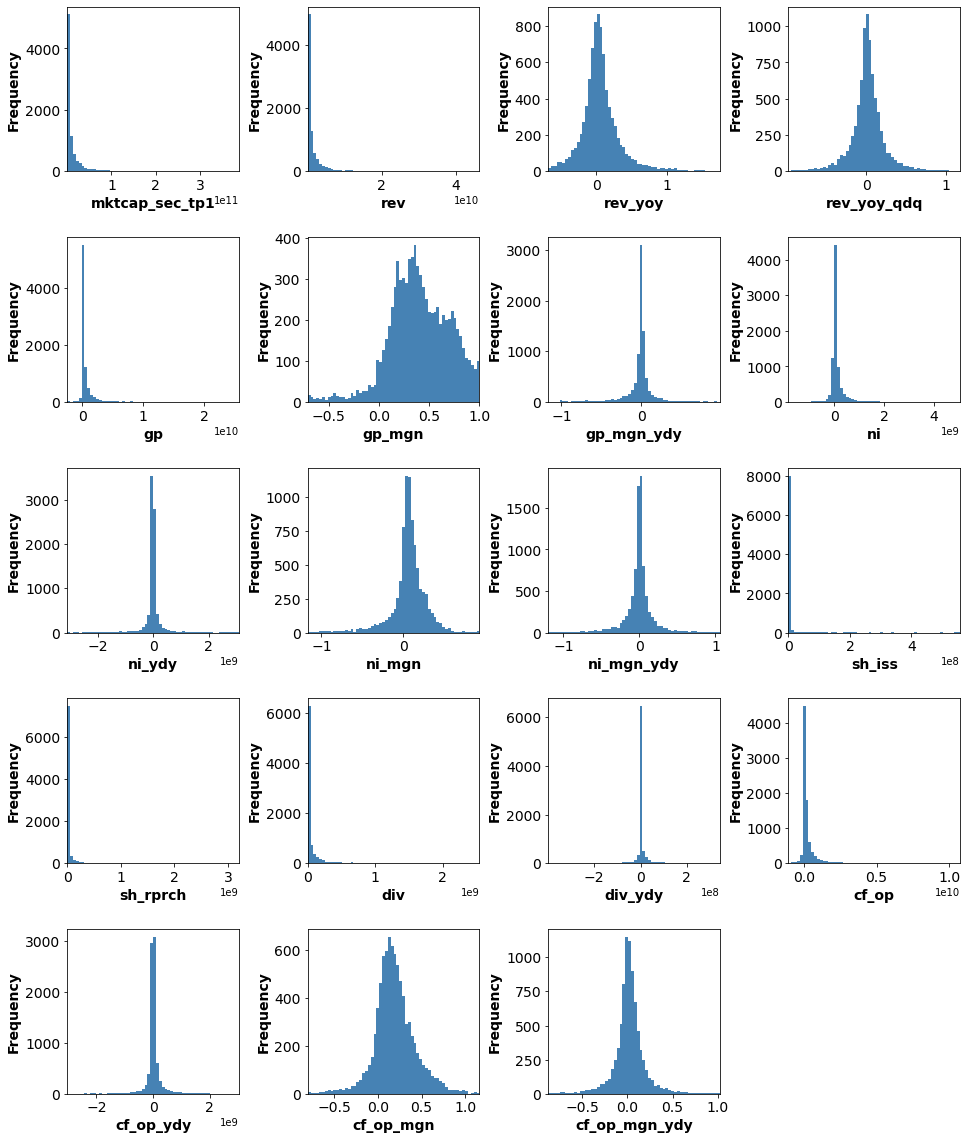

In [23]:
#plot histograms
fig04, axes04 = plt.subplots(nrows=5,ncols=4,figsize=(16,20))
fig04.subplots_adjust(wspace=0.4,hspace=0.4)
axes_flt04 = axes04.flatten()

lst_yx_coremet_plt04 = [
    'mktcap_sec_tp1',
    'rev', 'rev_yoy', 'rev_yoy_qdq', 
    'gp', 'gp_mgn', 'gp_mgn_ydy', 
    'ni', 'ni_ydy', 'ni_mgn', 'ni_mgn_ydy', 
    'sh_iss', 'sh_rprch', 'div', 'div_ydy',
    'cf_op', 'cf_op_ydy', 'cf_op_mgn', 'cf_op_mgn_ydy']
n_coremet01 = len(lst_yx_coremet_plt04)

for idx004 in range(0,n_coremet01):
    colplt04 = lst_yx_coremet_plt04[idx004]
    
    #bins
    lwbd04 = df_sec_yxdata011.loc[is_yx_inscope011,colplt04].quantile(0.005)
    upbd04 = df_sec_yxdata011.loc[is_yx_inscope011,colplt04].quantile(0.995)
    bwdth04 = (upbd04 - lwbd04)/60
    bin_p04 = np.arange(lwbd04, upbd04 + bwdth04, bwdth04)
    axes_flt04[idx004].set_xlim(lwbd04,upbd04)
    
    df_sec_yxdata011.loc[is_yx_inscope011,colplt04].plot(ax=axes_flt04[idx004],kind='hist',
        bins=bin_p04,color='steelblue')
    axes_flt04[idx004].set_xlabel(colplt04, fontsize=14.0, fontweight='bold')
    axes_flt04[idx004].tick_params(axis='x', labelsize=14)
    axes_flt04[idx004].set_ylabel('Frequency', fontsize=14.0, fontweight='bold') 
    axes_flt04[idx004].tick_params(axis='y', labelsize=14) 

axes_flt04[-1].set_visible(False)

## 3 Target-Feature Correlations

<b>3.0 DEFINE Y, X DATA FOR REGRESSION</b>

In [24]:
#define core metrics, data
lst_yx_coreattmet031 = ['ticker','mkt_cap_202109','rpt_ccy','inscope_flg',
    'fisc_date_t', 'fisc_date_tm1', 'fisc_date_tm4', 'fisc_date_tm5',
    'mktcap_sec_tp1',
    'clsadj_etf_t',
    'rev', 'rev_yoy', 'rev_yoy_qdq', 
    'gp', 'gp_mgn', 'gp_mgn_ydy', 
    'ni', 'ni_ydy', 'ni_mgn', 'ni_mgn_ydy', 
    'sh_iss', 'sh_rprch', 'div', 'div_ydy',
    'cf_op', 'cf_op_ydy', 'cf_op_mgn', 'cf_op_mgn_ydy']

#in scope
df_sec_yxdata_eda031 = df_sec_yxdata011.loc[is_yx_inscope011,lst_yx_coreattmet031].copy()
df_sec_yxdata_eda031.reset_index(drop=True,inplace=True)

In [25]:
df_sec_yxdata_eda031.describe()

,mkt_cap_202109,mktcap_sec_tp1,clsadj_etf_t,rev,rev_yoy,rev_yoy_qdq,gp,gp_mgn,gp_mgn_ydy,ni,...,ni_mgn,ni_mgn_ydy,sh_iss,sh_rprch,div,div_ydy,cf_op,cf_op_ydy,cf_op_mgn,cf_op_mgn_ydy
count,8.537000e+03,8.537000e+03,8537.000000,8.537000e+03,8537.000000,8537.000000,8.537000e+03,8537.000000,8537.000000,8.537000e+03,...,8537.000000,8537.000000,8.537000e+03,8.537000e+03,8.537000e+03,8.537000e+03,8.537000e+03,8.537000e+03,8537.000000,8537.000000
mean,2.738327e+10,2.209565e+10,168.458560,2.327204e+09,0.084006,0.024306,8.915585e+08,0.420081,-0.023362,1.663693e+08,...,0.061413,-0.009171,1.490740e+07,8.290046e+07,9.790665e+07,-3.025066e+05,3.729069e+08,1.520234e+07,0.193108,0.021149
std,1.193874e+11,9.449045e+10,28.477010,7.205580e+09,0.717955,0.433521,3.819480e+09,0.328131,0.248020,1.303779e+09,...,0.255865,0.248844,2.268327e+08,6.878668e+08,3.758400e+08,1.737248e+08,1.533799e+09,8.945202e+08,0.269837,0.228413
min,1.005768e+09,1.525262e+06,116.923459,7.584602e+06,-0.901738,-7.042663,-4.394700e+10,-1.679525,-1.970180,-4.974600e+10,...,-1.993759,-1.974594,0.000000e+00,0.000000e+00,0.000000e+00,-6.338000e+09,-2.539000e+10,-2.734100e+10,-1.900521,-1.953651
25%,2.452745e+09,1.875828e+09,149.372937,2.044640e+08,-0.078360,-0.069473,5.923800e+07,0.215076,-0.033840,1.064000e+06,...,0.002762,-0.051922,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.940100e+07,-2.286300e+07,0.059863,-0.047920
50%,5.806723e+09,4.381108e+09,167.704415,5.450800e+08,0.033025,0.014415,1.829220e+08,0.399000,0.000000,3.399300e+07,...,0.070327,0.002560,0.000000e+00,0.000000e+00,9.300000e+06,0.000000e+00,7.950300e+07,8.100000e+06,0.173987,0.016944
75%,1.760174e+10,1.416679e+10,191.404873,1.683100e+09,0.165256,0.108667,5.530000e+08,0.652937,0.026964,1.308480e+08,...,0.162301,0.048666,0.000000e+00,3.009000e+06,4.800000e+07,2.797000e+06,2.542700e+08,5.796200e+07,0.312865,0.090971
max,2.358033e+12,2.278942e+12,217.350477,1.520790e+11,45.359990,25.340377,1.255550e+11,1.690350,1.859718,3.583500e+10,...,1.987763,1.967329,1.729000e+10,2.477500e+10,8.296000e+09,8.296000e+09,3.876300e+10,1.168100e+10,1.998658,1.993663


In [26]:
#check na
df_sec_yxdata_eda031.isna().any()

ticker            False
mkt_cap_202109    False
rpt_ccy           False
inscope_flg       False
fisc_date_t       False
fisc_date_tm1     False
fisc_date_tm4     False
fisc_date_tm5     False
mktcap_sec_tp1    False
clsadj_etf_t      False
rev               False
rev_yoy           False
rev_yoy_qdq       False
gp                False
gp_mgn            False
gp_mgn_ydy        False
ni                False
ni_ydy            False
ni_mgn            False
ni_mgn_ydy        False
sh_iss            False
sh_rprch          False
div               False
div_ydy           False
cf_op             False
cf_op_ydy         False
cf_op_mgn         False
cf_op_mgn_ydy     False
dtype: bool

In [27]:
#scale the data
#core attributes, target & features, features
lst_yx_coreatt031 = ['ticker','mkt_cap_202109','rpt_ccy','inscope_flg',
    'fisc_date_t', 'fisc_date_tm1', 'fisc_date_tm4', 'fisc_date_tm5' ]
lst_yx_coretrgtfeat031 = [
    'mktcap_sec_tp1',
    'clsadj_etf_t',
    'rev', 'rev_yoy', 'rev_yoy_qdq', 
    'gp', 'gp_mgn', 'gp_mgn_ydy', 
    'ni', 'ni_ydy', 'ni_mgn', 'ni_mgn_ydy', 
    'sh_iss', 'sh_rprch', 'div', 'div_ydy',
    'cf_op', 'cf_op_ydy', 'cf_op_mgn', 'cf_op_mgn_ydy']
lst_yx_corefeat031 = [
    'clsadj_etf_t',
    'rev', 'rev_yoy', 'rev_yoy_qdq', 
    'gp', 'gp_mgn', 'gp_mgn_ydy', 
    'ni', 'ni_ydy', 'ni_mgn', 'ni_mgn_ydy', 
    'sh_iss', 'sh_rprch', 'div', 'div_ydy',
    'cf_op', 'cf_op_ydy', 'cf_op_mgn', 'cf_op_mgn_ydy']

#scale the data
#scaler031 = StandardScaler()
scaler031 = RobustScaler()
sclprm_feat031 = scaler031.fit(df_sec_yxdata_eda031.loc[:,lst_yx_coretrgtfeat031])
yxscaled_feat031 = scaler031.fit_transform(df_sec_yxdata_eda031.loc[:,lst_yx_coretrgtfeat031])

df_sec_yxdata_scaled031 = pd.DataFrame(yxscaled_feat031, columns=lst_yx_coretrgtfeat031)

In [28]:
#combine attribute, target, feature data
df_sec_yxdata_reg031 = pd.concat( [df_sec_yxdata_eda031.loc[:,lst_yx_coreatt031], df_sec_yxdata_scaled031 ], axis=1 )
df_sec_yxdata_reg031.describe()

,mkt_cap_202109,mktcap_sec_tp1,clsadj_etf_t,rev,rev_yoy,rev_yoy_qdq,gp,gp_mgn,gp_mgn_ydy,ni,...,ni_mgn,ni_mgn_ydy,sh_iss,sh_rprch,div,div_ydy,cf_op,cf_op_ydy,cf_op_mgn,cf_op_mgn_ydy
count,8.537000e+03,8537.000000,8537.000000,8537.000000,8537.000000,8537.000000,8537.000000,8537.000000,8537.000000,8537.000000,...,8537.000000,8537.000000,8.537000e+03,8537.000000,8537.000000,8537.000000,8537.000000,8537.000000,8537.000000,8537.000000
mean,2.738327e+10,1.441265,0.017942,1.205249,0.209266,0.055523,1.435178,0.048146,-0.384216,1.019974,...,-0.055872,-0.116622,1.490740e+07,27.550835,1.845972,-0.108154,1.249224,0.087873,0.075577,0.030279
std,1.193874e+11,7.687796,0.677509,4.873126,2.947067,2.433595,7.735469,0.749395,4.079024,10.045763,...,1.603771,2.473901,2.268327e+08,228.603135,7.829999,62.111104,6.530443,11.067370,1.066542,1.644544
min,1.005768e+09,-0.356325,-1.208152,-0.363508,-3.837023,-39.615350,-89.374885,-4.746997,-32.402223,-383.560323,...,-12.937766,-19.655996,0.000000e+00,0.000000,-0.193750,-2265.999285,-108.441314,-338.374265,-8.199570,-14.188020
25%,2.452745e+09,-0.203831,-0.436132,-0.230358,-0.457216,-0.470911,-0.250493,-0.420051,-0.556542,-0.253722,...,-0.423500,-0.541637,0.000000e+00,0.000000,-0.193750,0.000000,-0.255896,-0.383087,-0.451082,-0.467010
50%,5.806723e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.760174e+10,0.796169,0.563868,0.769642,0.542784,0.529089,0.749507,0.579949,0.443458,0.746278,...,0.576500,0.458363,0.000000e+00,1.000000,0.806250,1.000000,0.744104,0.616913,0.548918,0.532990
max,2.358033e+12,185.059562,1.181151,102.482234,186.058596,142.168876,253.911962,2.949224,30.585529,275.850698,...,12.018561,19.532868,1.729000e+10,8233.632436,172.639583,2966.035038,164.702438,144.421899,7.212079,14.232113


<b>3.1 INDIVIDUAL FEATURE REGRESSIONS</b>

In [29]:
#fit regression models over individual features
n_corefeat031 = len(lst_yx_corefeat031)

reg_res031 = []
ct031 = 0
for i031 in range(0,n_corefeat031):
    ct031 = ct031 + 1
        
    #features
    #labels
    f1_031 = lst_yx_corefeat031[i031]
    f1f1_031 = f1_031 + '_x_' + f1_031

    #dataframe for regression
    yxcolset031 = ['mktcap_sec_tp1',f1_031]
    df_sec_yxreg031 = df_sec_yxdata_reg031.loc[:,yxcolset031].copy()
    df_sec_yxreg031.loc[:,f1f1_031] = df_sec_yxdata_reg031.loc[:,f1_031] * df_sec_yxdata_reg031.loc[:,f1_031]
    df_sec_yxreg031.loc[:,'intcpt'] = 1
        
    #regression by formula
    mod_stg031 = 'mktcap_sec_tp1 ~ -1 + intcpt + ' + f1_031 + ' + ' +  f1f1_031 
    LM_mod031 = ols(mod_stg031,df_sec_yxreg031).fit()
    LM_anova031 = anova_lm(LM_mod031)
    print(mod_stg031)   
        
    #save fit metrics
    nobs031 = int(LM_mod031._results.nobs)
    mse031 = LM_anova031.loc['Residual','mean_sq']
    rsq031 = LM_mod031._results.rsquared
    b031 = LM_mod031._results.params
    #sums of squares
    SS_intcpt031 = LM_anova031.loc['intcpt','sum_sq']
    SS_f1_031 = LM_anova031.loc[f1_031,'sum_sq']
    SS_f1f1_031 = LM_anova031.loc[f1f1_031,'sum_sq']
    SS_err031 = LM_anova031.loc['Residual','sum_sq']
    SS_tot_031 = SS_intcpt031 + SS_f1_031 + SS_f1f1_031 + SS_err031
    #pct variance explained
    SSpct_intcpt031 = SS_intcpt031/SS_tot_031
    SSpct_f1_031 = SS_f1_031/SS_tot_031
    SSpct_f1f1_031 = SS_f1f1_031/SS_tot_031
    SSpct_err031 = SS_err031/SS_tot_031
    #save results
    reg_res031.append( [ ct031,f1_031, LM_mod031,LM_anova031,nobs031,mse031,rsq031,b031,
        SS_intcpt031, SS_f1_031,SS_f1f1_031,SS_err031,SS_tot_031,
        SSpct_intcpt031, SSpct_f1_031,SSpct_f1f1_031,SSpct_err031 ] )
        
#results to dataframe
df_reg_res031 = pd.DataFrame(reg_res031)
df_reg_res031.columns = [ 'iteration','feat1','lin_model','anova','nobs','mse','rsq','b', 
    'SS_intcpt','SS_f1','SS_f1f1','SS_err','SS_tot',
    'SSpct_intcpt','SSpct_f1','SSpct_f1f1','SSpct_err' ]
df_reg_res031.sort_values(by='mse',inplace=True)
df_reg_res031.reset_index(inplace=True,drop=True)


mktcap_sec_tp1 ~ -1 + intcpt + clsadj_etf_t + clsadj_etf_t_x_clsadj_etf_t
mktcap_sec_tp1 ~ -1 + intcpt + rev + rev_x_rev
mktcap_sec_tp1 ~ -1 + intcpt + rev_yoy + rev_yoy_x_rev_yoy
mktcap_sec_tp1 ~ -1 + intcpt + rev_yoy_qdq + rev_yoy_qdq_x_rev_yoy_qdq
mktcap_sec_tp1 ~ -1 + intcpt + gp + gp_x_gp
mktcap_sec_tp1 ~ -1 + intcpt + gp_mgn + gp_mgn_x_gp_mgn
mktcap_sec_tp1 ~ -1 + intcpt + gp_mgn_ydy + gp_mgn_ydy_x_gp_mgn_ydy
mktcap_sec_tp1 ~ -1 + intcpt + ni + ni_x_ni
mktcap_sec_tp1 ~ -1 + intcpt + ni_ydy + ni_ydy_x_ni_ydy
mktcap_sec_tp1 ~ -1 + intcpt + ni_mgn + ni_mgn_x_ni_mgn
mktcap_sec_tp1 ~ -1 + intcpt + ni_mgn_ydy + ni_mgn_ydy_x_ni_mgn_ydy
mktcap_sec_tp1 ~ -1 + intcpt + sh_iss + sh_iss_x_sh_iss
mktcap_sec_tp1 ~ -1 + intcpt + sh_rprch + sh_rprch_x_sh_rprch
mktcap_sec_tp1 ~ -1 + intcpt + div + div_x_div
mktcap_sec_tp1 ~ -1 + intcpt + div_ydy + div_ydy_x_div_ydy
mktcap_sec_tp1 ~ -1 + intcpt + cf_op + cf_op_x_cf_op
mktcap_sec_tp1 ~ -1 + intcpt + cf_op_ydy + cf_op_ydy_x_cf_op_ydy
mktcap_sec_tp1 

In [30]:
#single features, top models
df_reg_res031.head(10)

,iteration,feat1,lin_model,anova,nobs,mse,rsq,b,SS_intcpt,SS_f1,SS_f1f1,SS_err,SS_tot,SSpct_intcpt,SSpct_f1,SSpct_f1f1,SSpct_err
0,16,cf_op,<statsmodels.regression.linear_model.Regressio...,df sum_sq me...,8537,23.242462,0.606833,"[0.4800353499936604, 0.6113430279791245, 0.004...",17733.448434,283149.874137,22995.430056,198351.168489,522229.921117,0.033957,0.542194,0.044033,0.379816
1,8,ni,<statsmodels.regression.linear_model.Regressio...,df sum_sq mean_sq...,8537,28.785665,0.513065,"[0.8505527500088572, 0.44050397691222365, 0.00...",17733.448434,183787.612399,75051.994001,245656.866283,522229.921117,0.033957,0.351929,0.143714,0.470400
2,13,sh_rprch,<statsmodels.regression.linear_model.Regressio...,df sum_sq ...,8537,30.258369,0.488153,"[0.6705298477092014, 0.03164229563051746, -1.9...",17733.448434,237010.073143,9261.477185,258224.922355,522229.921117,0.033957,0.453842,0.017734,0.494466
3,5,gp,<statsmodels.regression.linear_model.Regressio...,df sum_sq mean_sq...,8537,34.016688,0.424578,"[0.47745608491869856, 0.6961197604354323, -0.0...",17733.448434,213245.123833,952.934512,290298.414338,522229.921117,0.033957,0.408336,0.001825,0.555882
4,2,rev,<statsmodels.regression.linear_model.Regressio...,df sum_sq mean_s...,8537,34.467052,0.416960,"[0.12365438252570664, 1.1535887405011898, -0.0...",17733.448434,208721.600440,1633.052972,294141.819271,522229.921117,0.033957,0.399674,0.003127,0.563242
5,17,cf_op_ydy,<statsmodels.regression.linear_model.Regressio...,df sum_sq ...,8537,47.659793,0.193793,"[1.2226936063943448, 0.34269148920717707, 0.00...",17733.448434,34179.806244,63587.995561,406728.670877,522229.921117,0.033957,0.065450,0.121762,0.778831
6,14,div,<statsmodels.regression.linear_model.Regressio...,df sum_sq mean_sq...,8537,47.981872,0.188345,"[0.5458525825075126, 0.5359069251461663, -0.00...",17733.448434,92336.734155,2682.442722,409477.295805,522229.921117,0.033957,0.176812,0.005137,0.784094
7,9,ni_ydy,<statsmodels.regression.linear_model.Regressio...,df sum_sq m...,8537,55.132242,0.067390,"[1.416626705470963, 0.0729765015812458, 8.1670...",17733.448434,13817.170483,20180.745856,470498.556344,522229.921117,0.033957,0.026458,0.038643,0.900941
8,15,div_ydy,<statsmodels.regression.linear_model.Regressio...,df sum_sq ...,8537,58.227573,0.015030,"[1.4208053186147835, 0.010428856928066322, 5.5...",17733.448434,3227.067349,4355.297225,496914.108108,522229.921117,0.033957,0.006179,0.008340,0.951524
9,10,ni_mgn,<statsmodels.regression.linear_model.Regressio...,df sum_sq m...,8537,58.781507,0.005659,"[1.4353569310540428, 0.3774671903859519, 0.010...",17733.448434,2782.576471,72.517928,501641.378283,522229.921117,0.033957,0.005328,0.000139,0.960576


In [31]:
#example, best single feature
df_reg_res031.loc[0,'lin_model'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         mktcap_sec_tp1   R-squared:                       0.607
Model:                            OLS   Adj. R-squared:                  0.607
Method:                 Least Squares   F-statistic:                     6586.
Date:                Wed, 13 Oct 2021   Prob (F-statistic):               0.00
Time:                        22:31:51   Log-Likelihood:                -25541.
No. Observations:                8537   AIC:                         5.109e+04
Df Residuals:                    8534   BIC:                         5.111e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
intcpt            0.4800      0.053      9.004      0.000       0.376       0.585
cf_op             0.6113      0.012     52.068      0.000       0.588       0.634
cf_op_x_cf_op     0.0045      0.000     31.454      0.000       0.004       0.005
==============================================================================
Omnibus:                    10160.492   Durbin-Watson:                   1.317
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         19635154.651
Skew:                           5.297   Prob(JB):                         0.00
Kurtosis:                     237.708   Cond. No.                         554.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

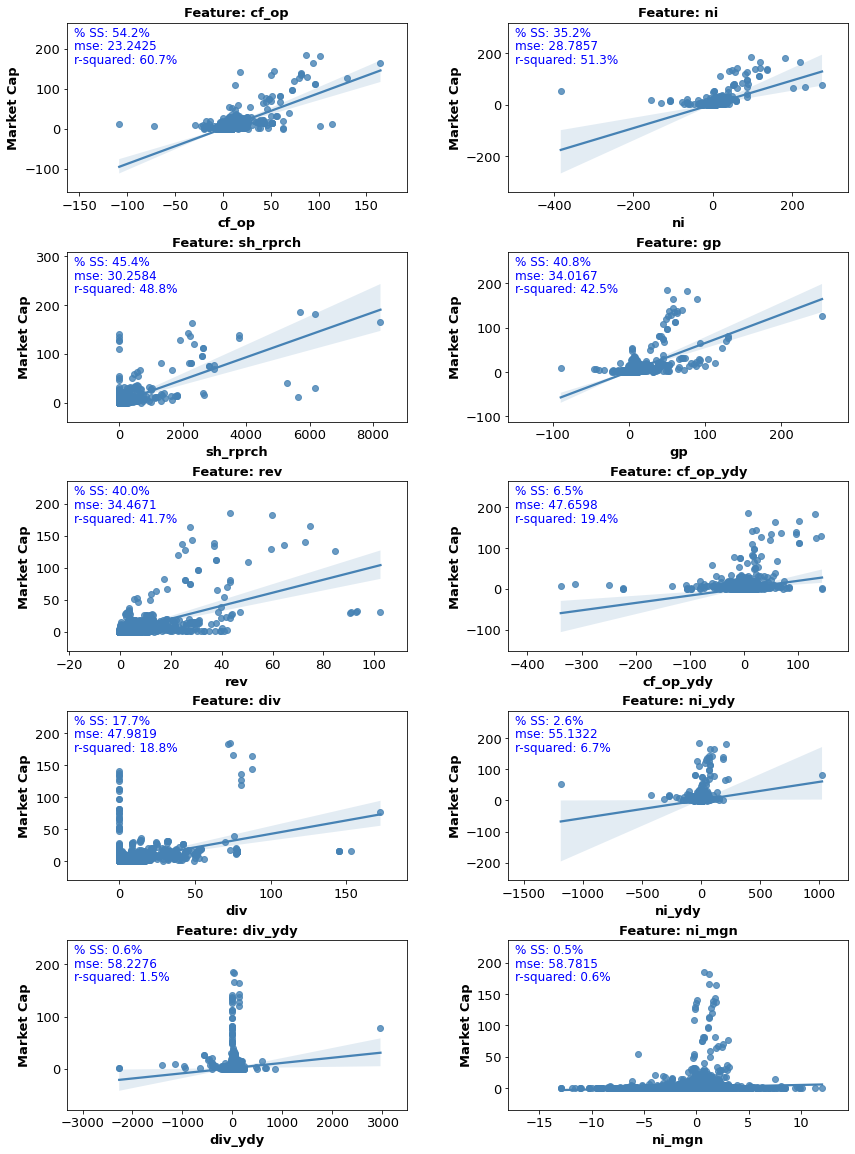

In [32]:
#scatterplots: individual features
fig05, axes05 = plt.subplots(nrows=5,ncols=2,figsize=(14,20))
fig05.subplots_adjust(wspace=0.3, hspace=0.35)
axes05_flt = axes05.flatten()

#loop models
for ct032 in range(0,10):
    
    #record
    rcd032 = df_reg_res031.loc[ct032,:]
    
    #labels
    f1_032 = rcd032['feat1']
    SSpctfeat032 = rcd032['SSpct_f1']
    mse032 = rcd032['mse']
    rsq032 = rcd032['rsq']
    
    #scatterplot
    axes05_n = axes05_flt[ct032]
    sns.regplot(ax=axes05_n,x=df_sec_yxdata_reg031.loc[:,f1_032],y=df_sec_yxdata_reg031.loc[:,'mktcap_sec_tp1'],color='steelblue')
    axes05_n.set_title('Feature: ' + f1_032, fontsize=13.0, fontweight='bold')
    axes05_n.set_xlabel(f1_032, fontsize=13.0, fontweight='bold')
    axes05_n.tick_params(axis='x', labelsize=13)
    axes05_n.set_ylabel('Market Cap', fontsize=13.0, fontweight='bold')
    axes05_n.tick_params(axis='y', labelsize=13) 

    #annotate scatter plot
    x_lim_rng05 = axes05_n.get_xlim()[1] - axes05_n.get_xlim()[0]
    y_lim_rng05 = axes05_n.get_ylim()[1] - axes05_n.get_ylim()[0]
    axes05_n.set_ylim(axes05_n.get_ylim()[0] - 0.10*y_lim_rng05,axes05_n.get_ylim()[1] + 0.20*y_lim_rng05)
    axes05_n.set_xlim(axes05_n.get_xlim()[0] - 0.20*x_lim_rng05,axes05_n.get_xlim()[1] + 0.10*x_lim_rng05)
    
    x_lim_rng05 = axes05_n.get_xlim()[1] - axes05_n.get_xlim()[0]
    y_lim_rng05 = axes05_n.get_ylim()[1] - axes05_n.get_ylim()[0]

    x_text05 = axes05_n.get_xlim()[0] + 0.02*x_lim_rng05
    
    y_SSpctfeat05 = axes05_n.get_ylim()[1] - 0.08*y_lim_rng05
    y_mse05 = axes05_n.get_ylim()[1] - 0.16*y_lim_rng05
    y_rsq05 = axes05_n.get_ylim()[1] - 0.24*y_lim_rng05
    
    SSpctfeat_text05 = '% SS: ' + '{:.1%}'.format(SSpctfeat032)
    mse_text05 = 'mse: ' + '{:.4f}'.format(mse032)
    rsq_text05 = 'r-squared: ' + '{:.1%}'.format(rsq032)

    axes05_n.text(x_text05, y_SSpctfeat05, SSpctfeat_text05, fontsize=12.0, color='blue')
    axes05_n.text(x_text05, y_mse05, mse_text05, fontsize=12.0, color='blue')
    axes05_n.text(x_text05, y_rsq05, rsq_text05, fontsize=12.0, color='blue')



<b>3.2 FEATURE PAIRS</b>

In [33]:
#fit regression models over pairs of features
n_corefeat032 = len(lst_yx_corefeat031)

reg_res032 = []
ct032 = 0
for i032 in range(0,n_corefeat032-1):
    for i033 in range(i032+1,n_corefeat032):
        ct032 = ct032 + 1
        
        #features
        #labels
        f1_032 = lst_yx_corefeat031[i032]
        f2_032 = lst_yx_corefeat031[i033]
        f1f1_032 = f1_032 + '_x_' + f1_032
        f2f2_032 = f2_032 + '_x_' + f2_032
        f1f2_032 = f1_032 + '_x_' + f2_032
        #dataframe for regression
        yxcolset032 = ['mktcap_sec_tp1',f1_032,f2_032]
        df_sec_yxreg032 = df_sec_yxdata_reg031.loc[:,yxcolset032].copy()
        df_sec_yxreg032.loc[:,f1f1_032] = df_sec_yxdata_reg031.loc[:,f1_032] * df_sec_yxdata_reg031.loc[:,f1_032]
        df_sec_yxreg032.loc[:,f2f2_032] = df_sec_yxdata_reg031.loc[:,f2_032] * df_sec_yxdata_reg031.loc[:,f2_032]
        df_sec_yxreg032.loc[:,f1f2_032] = df_sec_yxdata_reg031.loc[:,f1_032] * df_sec_yxdata_reg031.loc[:,f2_032]
        df_sec_yxreg032.loc[:,'intcpt'] = 1
        
        #regression by formula
        mod_stg032 = 'mktcap_sec_tp1 ~ -1 + intcpt + ' + f1_032 + ' + ' + f2_032 + ' + ' +  f1f1_032 + ' + ' + f2f2_032 + ' + ' + f1f2_032
        LM_mod032 = ols(mod_stg032,df_sec_yxreg032).fit()
        LM_anova032 = anova_lm(LM_mod032)
        if ct032%10 == 0:
            print(ct032,mod_stg032)   
        
        #save fit metrics
        nobs032 = int(LM_mod032._results.nobs)
        mse032 = LM_anova032.loc['Residual','mean_sq']
        rsq032 = LM_mod032._results.rsquared
        b032 = LM_mod032._results.params

        #sums of squares
        SS_intcpt032 = LM_anova032.loc['intcpt','sum_sq']
        SS_f1_032 = LM_anova032.loc[f1_032,'sum_sq']
        SS_f2_032 = LM_anova032.loc[f2_032,'sum_sq']
        SS_f1f1_032 = LM_anova032.loc[f1f1_032,'sum_sq']
        SS_f2f2_032 = LM_anova032.loc[f2f2_032,'sum_sq']
        SS_f1f2_032 = LM_anova032.loc[f1f2_032,'sum_sq']
        SS_err032 = LM_anova032.loc['Residual','sum_sq']
        SS_tot_032 = SS_intcpt032 + SS_f1_032 + SS_f2_032 + SS_f1f1_032 + SS_f2f2_032 + SS_f1f2_032 + SS_err032
        #pct variance explained
        SSpct_intcpt032 = SS_intcpt032/SS_tot_032
        SSpct_f1_032 = SS_f1_032/SS_tot_032
        SSpct_f2_032 = SS_f2_032/SS_tot_032
        SSpct_f1f1_032 = SS_f1f1_032/SS_tot_032
        SSpct_f2f2_032 = SS_f2f2_032/SS_tot_032
        SSpct_f1f2_032 = SS_f1f2_032/SS_tot_032
        SSpct_err032 = SS_err032/SS_tot_032
        #save results
        reg_res032.append( [ ct032,f1_032,f2_032, LM_mod032,LM_anova032,nobs032,mse032,rsq032,b032,
            SS_intcpt032,SS_f1_032,SS_f2_032,SS_f1f1_032,SS_f2f2_032,SS_f1f2_032,SS_err032,SS_tot_032,
            SSpct_intcpt032,SSpct_f1_032,SSpct_f2_032,SSpct_f1f1_032,SSpct_f2f2_032,SSpct_f1f2_032,SSpct_err032 ] )
        
#results to dataframe
df_reg_res032 = pd.DataFrame(reg_res032)
df_reg_res032.columns = ['iteration','feat1','feat2', 'lin_model','anova','nobs','mse','rsq','b', 
    'SS_intcpt','SS_f1','SS_f2','SS_f1f1','SS_f2f2','SS_f1f2','SS_err','SS_tot',
    'SSpct_intcpt','SSpct_f1','SSpct_f2','SSpct_f1f1','SSpct_f2f2','SSpct_f1f2','SSpct_err' ]
df_reg_res032.sort_values(by='mse',inplace=True)
df_reg_res032.reset_index(inplace=True,drop=True)

10 mktcap_sec_tp1 ~ -1 + intcpt + clsadj_etf_t + ni_mgn_ydy + clsadj_etf_t_x_clsadj_etf_t + ni_mgn_ydy_x_ni_mgn_ydy + clsadj_etf_t_x_ni_mgn_ydy
20 mktcap_sec_tp1 ~ -1 + intcpt + rev + rev_yoy_qdq + rev_x_rev + rev_yoy_qdq_x_rev_yoy_qdq + rev_x_rev_yoy_qdq
30 mktcap_sec_tp1 ~ -1 + intcpt + rev + div + rev_x_rev + div_x_div + rev_x_div
40 mktcap_sec_tp1 ~ -1 + intcpt + rev_yoy + ni + rev_yoy_x_rev_yoy + ni_x_ni + rev_yoy_x_ni
50 mktcap_sec_tp1 ~ -1 + intcpt + rev_yoy + cf_op_mgn + rev_yoy_x_rev_yoy + cf_op_mgn_x_cf_op_mgn + rev_yoy_x_cf_op_mgn
60 mktcap_sec_tp1 ~ -1 + intcpt + rev_yoy_qdq + sh_rprch + rev_yoy_qdq_x_rev_yoy_qdq + sh_rprch_x_sh_rprch + rev_yoy_qdq_x_sh_rprch
70 mktcap_sec_tp1 ~ -1 + intcpt + gp + ni_ydy + gp_x_gp + ni_ydy_x_ni_ydy + gp_x_ni_ydy
80 mktcap_sec_tp1 ~ -1 + intcpt + gp + cf_op_mgn_ydy + gp_x_gp + cf_op_mgn_ydy_x_cf_op_mgn_ydy + gp_x_cf_op_mgn_ydy
90 mktcap_sec_tp1 ~ -1 + intcpt + gp_mgn + cf_op + gp_mgn_x_gp_mgn + cf_op_x_cf_op + gp_mgn_x_cf_op
100 mktcap_sec_t

In [34]:
#feature pairs, top models
df_reg_res032.head(20)

,iteration,feat1,feat2,lin_model,anova,nobs,mse,rsq,b,SS_intcpt,...,SS_f1f2,SS_err,SS_tot,SSpct_intcpt,SSpct_f1,SSpct_f2,SSpct_f1f1,SSpct_f2f2,SSpct_f1f2,SSpct_err
0,153,sh_rprch,cf_op,<statsmodels.regression.linear_model.Regressio...,df sum_sq ...,8537,17.373199,0.706220,"[0.3443046612068576, 0.021024120334865087, 0.3...",17733.448434,...,8596.966302,148210.764221,522229.921117,0.033957,0.453842,0.172593,0.008674,0.030668,0.016462,0.283804
1,113,ni,cf_op,<statsmodels.regression.linear_model.Regressio...,df sum_sq me...,8537,18.800708,0.682081,"[0.48189757106036474, 0.18834712420908664, 0.4...",17733.448434,...,442.738190,160388.837388,522229.921117,0.033957,0.351929,0.246865,0.043137,0.016141,0.000848,0.307123
2,77,gp,cf_op,<statsmodels.regression.linear_model.Regressio...,df sum_sq me...,8537,19.837643,0.664547,"[0.3650092733622806, 0.371266058205468, 0.3358...",17733.448434,...,6280.262876,169234.936182,522229.921117,0.033957,0.408336,0.178702,0.000576,0.042341,0.012026,0.324062
3,32,rev,cf_op,<statsmodels.regression.linear_model.Regressio...,df sum_sq me...,8537,20.622577,0.651274,"[0.21666965068186178, 0.5605213719247046, 0.31...",17733.448434,...,3520.827997,175931.204915,522229.921117,0.033957,0.399674,0.181528,0.000107,0.041107,0.006742,0.336885
4,29,rev,sh_rprch,<statsmodels.regression.linear_model.Regressio...,df sum_sq ...,8537,21.103442,0.643142,"[0.1659888106030147, 0.6241299918812329, 0.020...",17733.448434,...,13031.607809,180033.459837,522229.921117,0.033957,0.399674,0.189320,0.000236,0.007120,0.024954,0.344740
5,132,ni_mgn,cf_op,<statsmodels.regression.linear_model.Regressio...,df sum_sq ...,8537,21.236341,0.640895,"[0.4968731384740196, 0.018174390651269575, 0.5...",17733.448434,...,16868.940887,181167.228140,522229.921117,0.033957,0.005328,0.537092,0.000200,0.044209,0.032302,0.346911
6,90,gp_mgn,cf_op,<statsmodels.regression.linear_model.Regressio...,df sum_sq ...,8537,21.320513,0.639472,"[0.4820837724321264, -0.046142928301341125, 0....",17733.448434,...,15734.805275,181885.292926,522229.921117,0.033957,0.003889,0.539272,0.000275,0.044191,0.030130,0.348286
7,123,ni_ydy,cf_op,<statsmodels.regression.linear_model.Regressio...,df sum_sq ...,8537,21.512216,0.636230,"[0.4951973500652525, -0.04055040170085174, 0.5...",17733.448434,...,6969.759109,183520.713640,522229.921117,0.033957,0.026458,0.522957,0.009814,0.042051,0.013346,0.351417
8,167,cf_op,cf_op_mgn,<statsmodels.regression.linear_model.Regressio...,df sum_sq ...,8537,21.852413,0.630477,"[0.6141851344591305, 0.5610292060750259, -0.43...",17733.448434,...,8206.248307,186422.933848,522229.921117,0.033957,0.542194,0.010863,0.038469,0.001828,0.015714,0.356975
9,24,rev,ni,<statsmodels.regression.linear_model.Regressio...,df sum_sq mean_s...,8537,21.927558,0.629207,"[0.22570048892512615, 0.6917788289463804, 0.30...",17733.448434,...,124.462564,187064.001339,522229.921117,0.033957,0.399674,0.146337,0.001172,0.060419,0.000238,0.358202


In [35]:
#example, best feature pair
df_reg_res032.loc[0,'lin_model'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         mktcap_sec_tp1   R-squared:                       0.706
Model:                            OLS   Adj. R-squared:                  0.706
Method:                 Least Squares   F-statistic:                     4102.
Date:                Wed, 13 Oct 2021   Prob (F-statistic):               0.00
Time:                        22:32:48   Log-Likelihood:                -24297.
No. Observations:                8537   AIC:                         4.861e+04
Df Residuals:                    8531   BIC:                         4.865e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
intcpt                  0.3443      0.046      7.434      0.000       0.254       0.435
sh_rprch                0.0210      0.000     45.085      0.000       0.020       0.022
cf_op                   0.3893      0.011     34.907      0.000       0.367       0.411
sh_rprch_x_sh_rprch -4.371e-06   1.26e-07    -34.686      0.000   -4.62e-06   -4.12e-06
cf_op_x_cf_op           0.0027      0.000     17.434      0.000       0.002       0.003
sh_rprch_x_cf_op        0.0002   6.88e-06     22.245      0.000       0.000       0.000
==============================================================================
Omnibus:                    13312.720   Durbin-Watson:                   1.227
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         30796999.904
Skew:                           9.298   Prob(JB):                         0.00
Kurtosis:                     296.656   Cond. No.                     1.20e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.2e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<b>3.2.1 FIRST ORDER FEATURES: PARTIAL RESIDUAL PLOTS</b>

In [36]:
#best 1st order features
df_reg_1stord_res0321 = df_reg_res032.loc[:,['feat1','SSpct_f1']].rename(
    columns={'feat1':'f_ord01','SSpct_f1':'SSpct_f_ord01'})
df_reg_1stord_res0321.loc[:,'idx_f_ord01'] = 1
df_reg_1stord_res0321 = pd.concat( [df_reg_1stord_res0321, df_reg_res032], axis=1)

df_reg_1stord_res0322 = df_reg_res032.loc[:,['feat2','SSpct_f2']].rename(
    columns={'feat2':'f_ord01','SSpct_f2':'SSpct_f_ord01'})
df_reg_1stord_res0322.loc[:,'idx_f_ord01'] = 2
df_reg_1stord_res0322 = pd.concat( [df_reg_1stord_res0322, df_reg_res032], axis=1)

df_reg_1stord_res0323 = pd.concat( [df_reg_1stord_res0321,df_reg_1stord_res0322], ignore_index=True )
df_reg_1stord_res0323.sort_values(by='SSpct_f_ord01',ascending=False,inplace=True)
df_reg_1stord_res0323.reset_index(inplace=True,drop=True)

#best model for each 1st order feature
df_1stord_idxmax0323 = df_reg_1stord_res0323.loc[:,['f_ord01','SSpct_f_ord01']].groupby(['f_ord01']).idxmax()
df_1stord_idxmax0323.rename(columns={'SSpct_f_ord01':'SSpct_f_ord01_idx'},inplace=True)
df_1stord_idxmax0323.sort_values(by='SSpct_f_ord01_idx',inplace=True)

df_reg_1stord_best0323 = df_reg_1stord_res0323.loc[df_1stord_idxmax0323.loc[:,'SSpct_f_ord01_idx'],:].copy()
df_reg_1stord_best0323.reset_index(inplace=True)
df_reg_1stord_best0323.rename(columns={'index':'idx_ord01'},inplace=True)
df_reg_1stord_best0323.head(10)

,idx_ord01,f_ord01,SSpct_f_ord01,idx_f_ord01,iteration,feat1,feat2,lin_model,anova,nobs,...,SS_f1f2,SS_err,SS_tot,SSpct_intcpt,SSpct_f1,SSpct_f2,SSpct_f1f1,SSpct_f2f2,SSpct_f1f2,SSpct_err
0,0,cf_op,0.542194,1,167,cf_op,cf_op_mgn,<statsmodels.regression.linear_model.Regressio...,df sum_sq ...,8537,...,8206.248307,186422.933848,522229.921117,0.033957,0.542194,0.010863,0.038469,0.001828,0.015714,0.356975
1,12,sh_rprch,0.453901,2,12,clsadj_etf_t,sh_rprch,<statsmodels.regression.linear_model.Regressio...,df su...,8537,...,21445.386748,235550.993785,522229.921117,0.033957,0.001313,0.453901,0.000507,0.018209,0.041065,0.451048
2,26,gp,0.408336,1,74,gp,sh_rprch,<statsmodels.regression.linear_model.Regressio...,df sum_sq ...,8537,...,3352.525944,193019.556739,522229.921117,0.033957,0.408336,0.178670,0.000139,0.002872,0.006420,0.369606
3,42,rev,0.399674,1,24,rev,ni,<statsmodels.regression.linear_model.Regressio...,df sum_sq mean_s...,8537,...,124.462564,187064.001339,522229.921117,0.033957,0.399674,0.146337,0.001172,0.060419,0.000238,0.358202
4,62,ni,0.353019,2,94,gp_mgn_ydy,ni,<statsmodels.regression.linear_model.Regressio...,df sum_sq...,8537,...,9762.501644,235358.497725,522229.921117,0.033957,0.000032,0.353019,0.000137,0.143481,0.018694,0.450680
5,82,div,0.187426,2,121,ni_ydy,div,<statsmodels.regression.linear_model.Regressio...,df sum_sq m...,8537,...,6102.264137,365138.047474,522229.921117,0.033957,0.026458,0.187426,0.034507,0.006776,0.011685,0.699190
6,103,ni_ydy,0.107033,2,106,ni,ni_ydy,<statsmodels.regression.linear_model.Regressio...,df sum_sq ...,8537,...,14.753756,200474.695635,522229.921117,0.033957,0.351929,0.107033,0.057522,0.065650,0.000028,0.383882
7,104,cf_op_ydy,0.066742,2,159,div,cf_op_ydy,<statsmodels.regression.linear_model.Regressio...,df sum_sq ...,8537,...,9115.105761,318826.526112,522229.921117,0.033957,0.176812,0.066742,0.006132,0.088392,0.017454,0.610510
8,144,cf_op_mgn_ydy,0.011588,2,170,cf_op_ydy,cf_op_mgn_ydy,<statsmodels.regression.linear_model.Regressio...,df ...,8537,...,40591.559341,357167.261066,522229.921117,0.033957,0.065450,0.011588,0.124655,0.002696,0.077727,0.683927
9,145,cf_op_mgn,0.010863,2,167,cf_op,cf_op_mgn,<statsmodels.regression.linear_model.Regressio...,df sum_sq ...,8537,...,8206.248307,186422.933848,522229.921117,0.033957,0.542194,0.010863,0.038469,0.001828,0.015714,0.356975


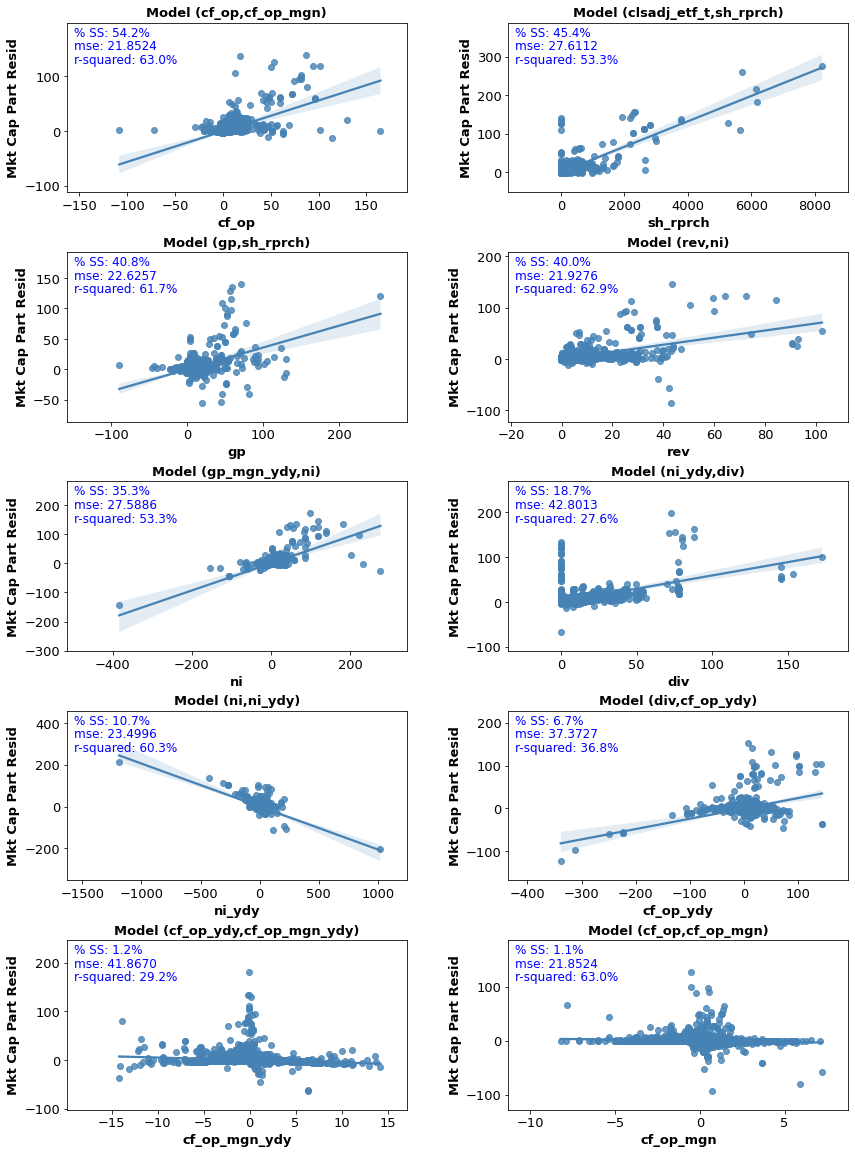

In [37]:
#partial residual plots: first order features, largest correlations
fig06, axes06 = plt.subplots(nrows=5,ncols=2,figsize=(14,20))
fig06.subplots_adjust(wspace=0.3, hspace=0.35)
axes06_flt = axes06.flatten()

#loop models
for ct032 in range(0,10):
    
    #record
    rcd0321 = df_reg_1stord_best0323.loc[ct032,:]
    
    #get focal feature attributes
    feat0321 = rcd0321['f_ord01']
    SSpctfeat0321 = rcd0321['SSpct_f_ord01']
    mse0321 = rcd0321['mse']
    rsq0321 = rcd0321['rsq']
    if rcd0321['idx_f_ord01'] == 1:
        b_feat0321 = rcd0321['b'][1]
    else:
        b_feat0321 = rcd0321['b'][2]
    
    #labels
    f1_032 = rcd0321['feat1']
    f2_032 = rcd0321['feat2']
    f1f1_032 = f1_032 + 'x' + f1_032
    f2f2_032 = f2_032 + 'x' + f2_032
    f1f2_032 = f1_032 + 'x' + f2_032  
    #dataframe for regression
    yxcolset032 = ['mktcap_sec_tp1',f1_032,f2_032]
    df_sec_yxreg032 = df_sec_yxdata_reg031.loc[:,yxcolset032].copy()
    df_sec_yxreg032.loc[:,f1f1_032] = df_sec_yxdata_reg031.loc[:,f1_032] * df_sec_yxdata_reg031.loc[:,f1_032]
    df_sec_yxreg032.loc[:,f2f2_032] = df_sec_yxdata_reg031.loc[:,f2_032] * df_sec_yxdata_reg031.loc[:,f2_032]
    df_sec_yxreg032.loc[:,f1f2_032] = df_sec_yxdata_reg031.loc[:,f1_032] * df_sec_yxdata_reg031.loc[:,f2_032]
    df_sec_yxreg032.loc[:,'intcpt'] = 1
    #arrays
    y_ary0321 = np.array(df_sec_yxreg032.loc[:,'mktcap_sec_tp1'])
    X_ary0321 = np.array(df_sec_yxreg032.loc[:,['intcpt',f1_032,f2_032,f1f1_032,f2f2_032,f1f2_032]])
    xfeat_ary0321 = np.array(df_sec_yxreg032.loc[:,feat0321])
    b_ary0321 = np.array(rcd0321['b'])
    y_part_ary0321 = y_ary0321 - np.matmul(X_ary0321,b_ary0321) + xfeat_ary0321*b_feat0321 
    
    #scatterplot
    axes06_n = axes06_flt[ct032]
    sns.regplot(ax=axes06_n,x=xfeat_ary0321,y=y_part_ary0321,color='steelblue')
    axes06_n.set_title('Model (' + f1_032 + ',' + f2_032 + ')' , fontsize=13.0, fontweight='bold')
    axes06_n.set_xlabel(feat0321, fontsize=13.0, fontweight='bold')
    axes06_n.tick_params(axis='x', labelsize=13)
    axes06_n.set_ylabel('Mkt Cap Part Resid', fontsize=13.0, fontweight='bold')
    axes06_n.tick_params(axis='y', labelsize=13) 

    #annotate scatter plot
    x_lim_rng06 = axes06_n.get_xlim()[1] - axes06_n.get_xlim()[0]
    y_lim_rng06 = axes06_n.get_ylim()[1] - axes06_n.get_ylim()[0]
    axes06_n.set_ylim(axes06_n.get_ylim()[0] - 0.10*y_lim_rng06,axes06_n.get_ylim()[1] + 0.20*y_lim_rng06)
    axes06_n.set_xlim(axes06_n.get_xlim()[0] - 0.20*x_lim_rng06,axes06_n.get_xlim()[1] + 0.10*x_lim_rng06)
    
    x_lim_rng06 = axes06_n.get_xlim()[1] - axes06_n.get_xlim()[0]
    y_lim_rng06 = axes06_n.get_ylim()[1] - axes06_n.get_ylim()[0]

    x_text06 = axes06_n.get_xlim()[0] + 0.02*x_lim_rng06
    
    y_SSpctfeat06 = axes06_n.get_ylim()[1] - 0.08*y_lim_rng06
    y_mse06 = axes06_n.get_ylim()[1] - 0.16*y_lim_rng06
    y_rsq06 = axes06_n.get_ylim()[1] - 0.24*y_lim_rng06
    
    SSpctfeat_text06 = '% SS: ' + '{:.1%}'.format(SSpctfeat0321)
    mse_text06 = 'mse: ' + '{:.4f}'.format(mse0321)
    rsq_text06 = 'r-squared: ' + '{:.1%}'.format(rsq0321)

    axes06_n.text(x_text06, y_SSpctfeat06, SSpctfeat_text06, fontsize=12.0, color='blue')
    axes06_n.text(x_text06, y_mse06, mse_text06, fontsize=12.0, color='blue')
    axes06_n.text(x_text06, y_rsq06, rsq_text06, fontsize=12.0, color='blue')


<b>3.2.2 SECOND ORDER FEATURES: PARTIAL RESIDUAL PLOTS</b>

In [38]:
#best 2nd order features
df_reg_2ndord_res0321 = df_reg_res032.loc[:,['feat1','SSpct_f1f1']].rename(
    columns={'feat1':'f_ord02','SSpct_f1f1':'SSpct_f_ord02'})
df_reg_2ndord_res0321.loc[:,'f_ord02'] = df_reg_2ndord_res0321.loc[:,'f_ord02'] + '_x_' + df_reg_2ndord_res0321.loc[:,'f_ord02']
df_reg_2ndord_res0321.loc[:,'idx_f_ord02'] = 3
df_reg_2ndord_res0321 = pd.concat( [df_reg_2ndord_res0321, df_reg_res032], axis=1)

df_reg_2ndord_res0322 = df_reg_res032.loc[:,['feat2','SSpct_f2f2']].rename(
    columns={'feat2':'f_ord02','SSpct_f2f2':'SSpct_f_ord02'})
df_reg_2ndord_res0322.loc[:,'f_ord02'] = df_reg_2ndord_res0322.loc[:,'f_ord02'] + '_x_' + df_reg_2ndord_res0322.loc[:,'f_ord02']
df_reg_2ndord_res0322.loc[:,'idx_f_ord02'] = 4
df_reg_2ndord_res0322 = pd.concat( [df_reg_2ndord_res0322, df_reg_res032], axis=1)

df_reg_2ndord_res0323 = df_reg_res032.loc[:,['feat1','SSpct_f1f2']].rename(
    columns={'feat1':'f_ord02','SSpct_f1f2':'SSpct_f_ord02'})
df_reg_2ndord_res0323.loc[:,'f_ord02'] = df_reg_res032.loc[:,'feat1'] + '_x_' + df_reg_res032.loc[:,'feat2']
df_reg_2ndord_res0323.loc[:,'idx_f_ord02'] = 5
df_reg_2ndord_res0323 = pd.concat( [df_reg_2ndord_res0323, df_reg_res032], axis=1)

df_reg_2ndord_res0323 = pd.concat( [df_reg_2ndord_res0323,df_reg_2ndord_res0322,df_reg_2ndord_res0321], ignore_index=True )
df_reg_2ndord_res0323.sort_values(by='SSpct_f_ord02',ascending=False,inplace=True)
df_reg_2ndord_res0323.reset_index(inplace=True,drop=True)

#best model for each 2nd order feature
df_2ndord_idxmax0323 = df_reg_2ndord_res0323.loc[:,['f_ord02','SSpct_f_ord02']].groupby(['f_ord02']).idxmax()
df_2ndord_idxmax0323.rename(columns={'SSpct_f_ord02':'SSpct_f_ord02_idx'},inplace=True)
df_2ndord_idxmax0323.sort_values(by='SSpct_f_ord02_idx',inplace=True)

df_reg_2ndord_best0323 = df_reg_2ndord_res0323.loc[df_2ndord_idxmax0323.loc[:,'SSpct_f_ord02_idx'],:].copy()
df_reg_2ndord_best0323.reset_index(inplace=True)
df_reg_2ndord_best0323.rename(columns={'index':'idx_ord02'},inplace=True)
df_reg_2ndord_best0323.head(20)

,idx_ord02,f_ord02,SSpct_f_ord02,idx_f_ord02,iteration,feat1,feat2,lin_model,anova,nobs,...,SS_f1f2,SS_err,SS_tot,SSpct_intcpt,SSpct_f1,SSpct_f2,SSpct_f1f1,SSpct_f2f2,SSpct_f1f2,SSpct_err
0,0,rev_x_cf_op_mgn,0.176771,5,34,rev,cf_op_mgn,<statsmodels.regression.linear_model.Regressio...,df sum_sq ...,8537,...,92314.929968,198966.207644,522229.921117,0.033957,0.399674,0.005151,0.003365,0.000089,0.176771,0.380994
1,1,ni_x_ni,0.155369,3,112,ni,div_ydy,<statsmodels.regression.linear_model.Regressio...,df sum_sq ...,8537,...,2851.726458,220139.512065,522229.921117,0.033957,0.351929,0.001516,0.155369,0.030231,0.005461,0.421538
2,11,rev_x_ni_mgn,0.139856,5,26,rev,ni_mgn,<statsmodels.regression.linear_model.Regressio...,df sum_sq ...,8537,...,73037.021583,217934.080903,522229.921117,0.033957,0.399674,0.004220,0.003019,0.001959,0.139856,0.417314
3,13,gp_x_cf_op_mgn,0.135716,5,79,gp,cf_op_mgn,<statsmodels.regression.linear_model.Regressio...,df sum_sq ...,8537,...,70875.056461,218455.702752,522229.921117,0.033957,0.408336,0.001866,0.001787,0.000025,0.135716,0.418313
4,14,cf_op_ydy_x_cf_op_ydy,0.124655,3,170,cf_op_ydy,cf_op_mgn_ydy,<statsmodels.regression.linear_model.Regressio...,df ...,8537,...,40591.559341,357167.261066,522229.921117,0.033957,0.065450,0.011588,0.124655,0.002696,0.077727,0.683927
5,24,sh_iss_x_div,0.115888,5,145,sh_iss,div,<statsmodels.regression.linear_model.Regressio...,df sum_sq m...,8537,...,66860.485811,391446.975530,576941.078281,0.030737,0.006129,0.158723,0.005779,0.004258,0.115888,0.678487
6,29,rev_yoy_x_ni,0.099192,5,40,rev_yoy,ni,<statsmodels.regression.linear_model.Regressio...,df sum_sq ...,8537,...,51801.021802,193770.665195,522229.921117,0.033957,0.000281,0.351654,0.000111,0.143760,0.099192,0.371045
7,30,ni_ydy_x_cf_op_ydy,0.099006,5,124,ni_ydy,cf_op_ydy,<statsmodels.regression.linear_model.Regressio...,df sum_sq ...,8537,...,51703.941635,338629.956188,522229.921117,0.033957,0.026458,0.053208,0.034773,0.104167,0.099006,0.648431
8,31,ni_ydy_x_ni_mgn,0.095675,5,117,ni_ydy,ni_mgn,<statsmodels.regression.linear_model.Regressio...,df sum_sq m...,8537,...,49964.104381,419185.235627,522229.921117,0.033957,0.026458,0.002435,0.038701,0.000091,0.095675,0.802683
9,33,cf_op_ydy_x_cf_op_mgn_ydy,0.077727,5,170,cf_op_ydy,cf_op_mgn_ydy,<statsmodels.regression.linear_model.Regressio...,df ...,8537,...,40591.559341,357167.261066,522229.921117,0.033957,0.065450,0.011588,0.124655,0.002696,0.077727,0.683927


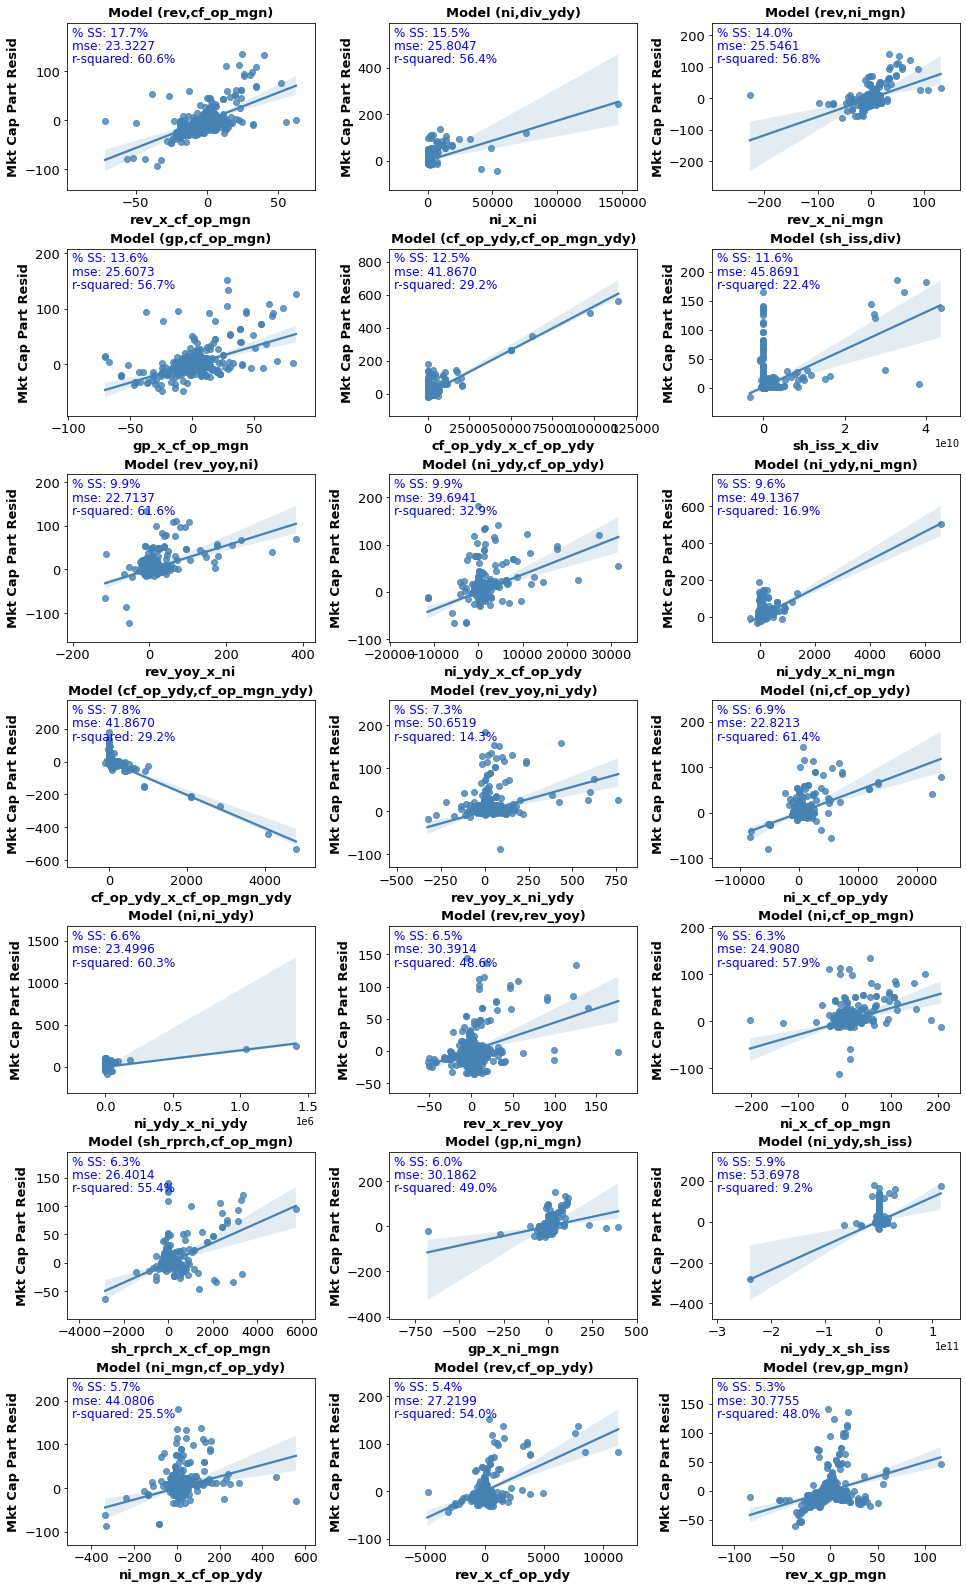

In [40]:
#partial residual plots: 2nd order features, largest correlations
fig07, axes07 = plt.subplots(nrows=7,ncols=3,figsize=(16,28))
fig07.subplots_adjust(wspace=0.3, hspace=0.35)
axes07_flt = axes07.flatten()

#loop models
for ct032 in range(0,21):
    
    #record
    rcd0322 = df_reg_2ndord_best0323.loc[ct032,:]
    
    #get focal feature attributes
    feat0322 = rcd0322['f_ord02']
    SSpctfeat0322 = rcd0322['SSpct_f_ord02']
    mse0322 = rcd0322['mse']
    rsq0322 = rcd0322['rsq']
    if rcd0322['idx_f_ord02'] == 3:
        b_feat0322 = rcd0322['b'][3]
    elif rcd0322['idx_f_ord02'] == 4:
        b_feat0322 = rcd0322['b'][4]
    else:
        b_feat0322 = rcd0322['b'][5]
    
    #labels
    f1_032 = rcd0322['feat1']
    f2_032 = rcd0322['feat2']
    f1f1_032 = f1_032 + '_x_' + f1_032
    f2f2_032 = f2_032 + '_x_' + f2_032
    f1f2_032 = f1_032 + '_x_' + f2_032  
    #dataframe for regression
    yxcolset032 = ['mktcap_sec_tp1',f1_032,f2_032]
    df_sec_yxreg032 = df_sec_yxdata_reg031.loc[:,yxcolset032].copy()
    df_sec_yxreg032.loc[:,f1f1_032] = df_sec_yxdata_reg031.loc[:,f1_032] * df_sec_yxdata_reg031.loc[:,f1_032]
    df_sec_yxreg032.loc[:,f2f2_032] = df_sec_yxdata_reg031.loc[:,f2_032] * df_sec_yxdata_reg031.loc[:,f2_032]
    df_sec_yxreg032.loc[:,f1f2_032] = df_sec_yxdata_reg031.loc[:,f1_032] * df_sec_yxdata_reg031.loc[:,f2_032]
    df_sec_yxreg032.loc[:,'intcpt'] = 1
    #arrays
    y_ary0322 = np.array(df_sec_yxreg032.loc[:,'mktcap_sec_tp1'])
    X_ary0322 = np.array(df_sec_yxreg032.loc[:,['intcpt',f1_032,f2_032,f1f1_032,f2f2_032,f1f2_032]])
    xfeat_ary0322 = np.array(df_sec_yxreg032.loc[:,feat0322])
    b_ary0322 = np.array(rcd0322['b'])
    y_part_ary0322 = y_ary0322 - np.matmul(X_ary0322,b_ary0322) + xfeat_ary0322*b_feat0322 
    
    #scatterplot
    axes07_n = axes07_flt[ct032]
    sns.regplot(ax=axes07_n,x=xfeat_ary0322,y=y_part_ary0322,color='steelblue')
    axes07_n.set_title('Model (' + f1_032 + ',' + f2_032 + ')' , fontsize=13.0, fontweight='bold')
    axes07_n.set_xlabel(feat0322, fontsize=13.0, fontweight='bold')
    axes07_n.tick_params(axis='x', labelsize=13)
    axes07_n.set_ylabel('Mkt Cap Part Resid', fontsize=13.0, fontweight='bold')
    axes07_n.tick_params(axis='y', labelsize=13) 

    #annotate scatter plot
    x_lim_rng07 = axes07_n.get_xlim()[1] - axes07_n.get_xlim()[0]
    y_lim_rng07 = axes07_n.get_ylim()[1] - axes07_n.get_ylim()[0]
    axes07_n.set_ylim(axes07_n.get_ylim()[0] - 0.10*y_lim_rng07,axes07_n.get_ylim()[1] + 0.20*y_lim_rng07)
    axes07_n.set_xlim(axes07_n.get_xlim()[0] - 0.20*x_lim_rng07,axes07_n.get_xlim()[1] + 0.10*x_lim_rng07)
    
    x_lim_rng07 = axes07_n.get_xlim()[1] - axes07_n.get_xlim()[0]
    y_lim_rng07 = axes07_n.get_ylim()[1] - axes07_n.get_ylim()[0]

    x_text07 = axes07_n.get_xlim()[0] + 0.02*x_lim_rng07
    
    y_SSpctfeat07 = axes07_n.get_ylim()[1] - 0.08*y_lim_rng07
    y_mse07 = axes07_n.get_ylim()[1] - 0.16*y_lim_rng07
    y_rsq07 = axes07_n.get_ylim()[1] - 0.24*y_lim_rng07
    
    SSpctfeat_text07 = '% SS: ' + '{:.1%}'.format(SSpctfeat0322)
    mse_text07 = 'mse: ' + '{:.4f}'.format(mse0322)
    rsq_text07 = 'r-squared: ' + '{:.1%}'.format(rsq0322)

    axes07_n.text(x_text07, y_SSpctfeat07, SSpctfeat_text07, fontsize=12.0, color='blue')
    axes07_n.text(x_text07, y_mse07, mse_text07, fontsize=12.0, color='blue')
    axes07_n.text(x_text07, y_rsq07, rsq_text07, fontsize=12.0, color='blue')



## 4 Conclusions

The key results of this exploratory data analysis notebook are:
<ol type="1">
  <li>abc</li>
  <li>abc</li>
</ol> 

In [ ]:
#save target, feature data: df_sec_yxdata031
data_elmt041 = 'yxdata_eda_'

#json
filnm041 = '../data/sec_' + data_elmt041 + statusdate01.strftime('%Y%m%d') + '.json'

df_sec_res_041 = df_sec_yxdata_eda031.copy()

#dates to strings
lst_yxdata_dates041 = ['fisc_date_t', 'fisc_date_tp1', 'meas_date_t', 'meas_date_tp1', 
    'rpt_date_t', 'rpt_date_tp1', 'fisc_date_tm1', 'fisc_date_tm4', 'fisc_date_tm5']

for lst_date_itm041 in lst_yxdata_dates041:
    df_sec_res_041.loc[:,lst_date_itm041] = df_sec_res_041.loc[:,lst_date_itm041].dt.strftime('%Y-%m-%d')

#df_sec_res_041.to_json(filnm041)